Backtesting

In [2]:
import pandas as pd
import matplotlib as plt
# Définir le chemin du fichier
chemin = r"C:\Users\Liam\Desktop\Projet crypto\Data\df_export.csvtrain_df.csv"

# Importer le DataFrame
train_df = pd.read_csv(chemin)

# Afficher les premières lignes pour vérifier
print(train_df.head())

             timestamp     open     high      low    close      volume  rsi  \
0  2021-04-01 00:00:00  1919.37  1937.82  1919.37  1934.49  5054.95614  NaN   
1  2021-04-01 00:05:00  1935.24  1935.25  1927.86  1927.90  1884.79818  NaN   
2  2021-04-01 00:10:00  1927.92  1929.63  1923.41  1926.55  2004.92272  NaN   
3  2021-04-01 00:15:00  1926.55  1928.76  1924.00  1924.80  1469.64577  NaN   
4  2021-04-01 00:20:00  1924.80  1929.78  1924.28  1928.29  1760.55796  NaN   

       macd  macd_signal  atr  volatility_20d  roc_5  roc_10    ema_short  \
0  0.000000     0.000000  NaN             NaN    NaN     NaN  1934.490000   
1 -0.147853    -0.082140  NaN             NaN    NaN     NaN  1931.121778   
2 -0.230257    -0.142844  NaN             NaN    NaN     NaN  1929.529631   
3 -0.325276    -0.204643  NaN             NaN    NaN     NaN  1928.267255   
4 -0.231185    -0.212539  NaN             NaN    NaN     NaN  1928.272217   

      ema_long  signal  
0  1934.490000       0  
1  1931.1776

In [3]:
sma_short = 45  # Période courte
sma_long = 190   # Période longue
# Calcul des Moyennes Mobiles
train_df["MM_courte"] = train_df["close"].rolling(window=sma_short).mean()
train_df["MM_longue"] = train_df["close"].rolling(window=sma_long).mean()

# Détecter les Signaux d'Achat/Vente
train_df["Signal"] = 0
train_df.loc[train_df["MM_courte"] > train_df["MM_longue"], "Signal"] = 1  # Achat
train_df.loc[train_df["MM_courte"] < train_df["MM_longue"], "Signal"] = -1  # Vente

Matplotlib is building the font cache; this may take a moment.
C:\Users\Liam\AppData\Local\Temp\ipykernel_8168\3206678562.py:88: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '5004.59' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  train_df.at[train_df.index[i], "Strat"] = capital + (position * close_price)
C:\Users\Liam\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


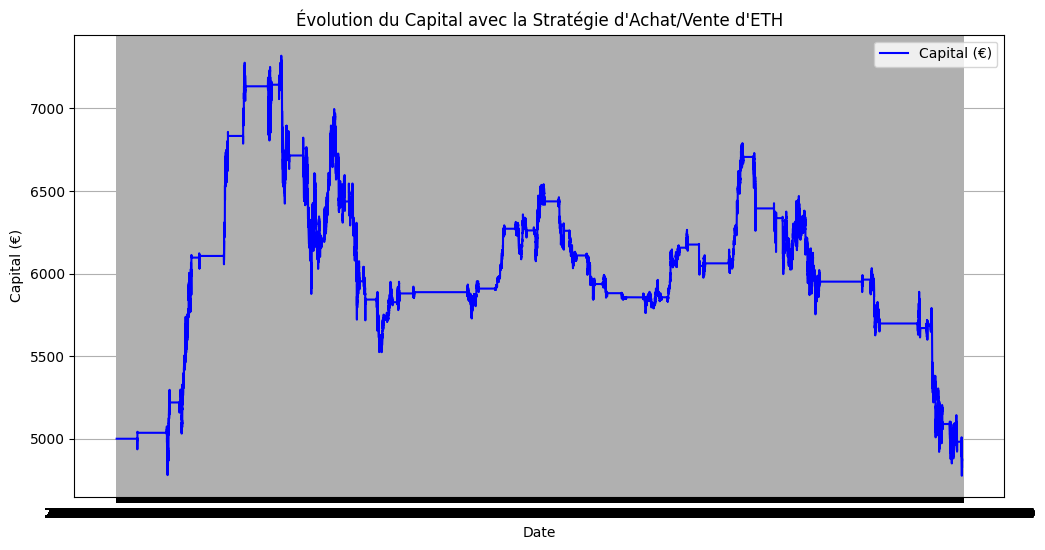

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Paramètres de backtest
initial_capital = 5000
capital = initial_capital
position = 0  # Nombre d'ETH détenus

# Calcul des Moyennes Mobiles
MM_courte = 45  # Période courte
MM_longue = 190  # Période longue

# Calcul des Moyennes Mobiles
train_df["MM_courte"] = train_df["close"].rolling(window=MM_courte).mean()
train_df["MM_longue"] = train_df["close"].rolling(window=MM_longue).mean()

# Calcul des indicateurs techniques (RSI, MACD, etc.)
def compute_rsi(series, window=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

def compute_macd(series, short_window=12, long_window=26, signal_window=9):
    short_ema = series.ewm(span=short_window, min_periods=1).mean()
    long_ema = series.ewm(span=long_window, min_periods=1).mean()
    macd = short_ema - long_ema
    macd_signal = macd.ewm(span=signal_window, min_periods=1).mean()
    return macd, macd_signal

def compute_atr(data, window=14):
    high_low = data["high"] - data["low"]
    high_close = np.abs(data["high"] - data["close"].shift())
    low_close = np.abs(data["low"] - data["close"].shift())
    tr = pd.DataFrame({"high_low": high_low, "high_close": high_close, "low_close": low_close}).max(axis=1)
    return tr.rolling(window=window).mean()

# Ajouter les indicateurs techniques
train_df["rsi"] = compute_rsi(train_df["close"], window=14)
train_df["macd"], train_df["macd_signal"] = compute_macd(train_df["close"])
train_df["atr"] = compute_atr(train_df)
train_df["volatility_20d"] = train_df["close"].pct_change().rolling(20).std()
train_df["roc_5"] = train_df["close"].pct_change(5)
train_df["roc_10"] = train_df["close"].pct_change(10)

# Définir les signaux dans la colonne Signal
train_df["Signal"] = 0  # Valeur par défaut de Signal est 0 (aucune action)

# Condition d'achat
train_df.loc[
    (train_df["MM_courte"] > train_df["MM_longue"]) &  # SMA croisement (achat)
    (train_df["rsi"] < 30) &  # RSI sous 30 (sur-vendu)
    (train_df["macd"] > train_df["macd_signal"]),  # MACD au-dessus de la ligne de signal
    "Signal"
] = 1  # Signal d'achat

# Condition de vente
train_df.loc[
    (train_df["MM_courte"] < train_df["MM_longue"]) &  # SMA croisement (vente)
    (train_df["rsi"] > 70) &  # RSI au-dessus de 70 (sur-acheté)
    (train_df["macd"] < train_df["macd_signal"]),  # MACD en-dessous de la ligne de signal
    "Signal"
] = -1  # Signal de vente

# Supprimer les lignes avec des valeurs manquantes dans les colonnes essentielles
train_df = train_df.dropna(subset=["Signal", "close", "timestamp", "rsi", "macd", "macd_signal"])

# Initialiser la colonne "Capital"
train_df["Strat"] = capital

# Backtest de la stratégie
for i in range(1, len(train_df)):
    signal = train_df["Signal"].iloc[i]
    close_price = train_df["close"].iloc[i]

    # Achat : signal 1
    if signal == 1 and position == 0 and capital >= close_price:
        position = 1
        capital -= close_price

    # Vente : signal -1
    elif signal == -1 and position == 1:
        capital += position * close_price
        position = 0

    # Mise à jour du capital total (cash + valeur de l'ETH détenu)
    train_df.at[train_df.index[i], "Strat"] = capital + (position * close_price)

# Affichage du graphique des profits et pertes
plt.figure(figsize=(12, 6))
plt.plot(train_df["timestamp"], train_df["Strat"], label="Capital (€)", color="blue")
plt.xlabel("Date")
plt.ylabel("Capital (€)")
plt.title("Évolution du Capital avec la Stratégie d'Achat/Vente d'ETH")
plt.legend()
plt.grid()
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Paramètres de backtest
initial_capital = 5000
capital = initial_capital
position = 0  # Nombre d'ETH détenus

# Initialiser la colonne "Strat" avec le capital de départ
train_df["BH"] = capital

# Acheter un ETH au tout début
initial_price = train_df["close"].iloc[0]  # Prix d'achat au début
capital -= initial_price  # Réduire le capital initial pour acheter l'ETH
position = 1  # Acheter 1 ETH

# Backtest de la stratégie
for i in range(1, len(train_df)):
    close_price = train_df["close"].iloc[i]
    
    # Mise à jour du capital total (cash + valeur de l'ETH détenu)
    train_df.at[train_df.index[i], "BH"] = capital + (position * close_price)

# Affichage du graphique des profits et pertes
plt.figure(figsize=(12, 6))
plt.plot(train_df["timestamp"], train_df["BH"], label="Capital (€)", color="blue")
plt.xlabel("Date")
plt.ylabel("Capital (€)")
plt.title("Évolution du Capital avec la Stratégie Buy and Hold (1 ETH acheté au début)")
plt.legend()
plt.grid()
plt.show()


C:\Users\Liam\AppData\Local\Temp\ipykernel_8168\3026447032.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '5001.53' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  train_df.at[train_df.index[i], "BH"] = capital + (position * close_price)
C:\Users\Liam\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


Méthode 2 uniquement Moyenne Mobile 